In [1]:
# Auto Reload
%load_ext autoreload
%autoreload 2

In [2]:
# Import Modules
from collections import Counter
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
from pprint import pprint
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from math import log

In [5]:
# NLTK Modules
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import enchant

In [10]:
# Import Data
df = pd.read_csv('data/articles.csv', index_col='index')

In [11]:
df.date = pd.to_datetime(df.date)

In [12]:
df.tail()

,title,url,date,tags,words,content
index,,,,,,
5694,"Immunity, Interdependence, and the Shared Root...",https://www.brainpickings.org/2021/03/19/eula-...,2021-03-19,"philosophy, science, books, eula-biss, culture...",1897,Months after Rachel Carson’s Silent Spring ...
5695,"Of Trees, Tenderness, and the Moon: Hasui Kawa...",https://www.brainpickings.org/2021/03/22/hasui...,2021-03-22,"hasui-kawase, culture, art, trees, japan,",817,“After you have exhausted what there is in bus...
5696,Our Greatest Misunderstanding About Love: Phil...,https://www.brainpickings.org/2021/03/23/esthe...,2021-03-23,"philosophy, esther-perel, love, culture, anima...",423,In his revelatory 1956 classic The Art of Lov...
5697,Secrets from the Center of the World: Poet Joy...,https://www.brainpickings.org/2021/03/25/secre...,2021-03-25,"joy-harjo, science, books, stephen-strom, cult...",1165,“Place and a mind may interpenetrate till the ...
5698,Seeking an Aurora: A Wondrous Illustrated Cele...,https://www.brainpickings.org/2021/03/28/seeki...,2021-03-28,"science, books, space, culture, art, illustrat...",692,"In 1621, already questioning his life in the p..."


In [91]:
word_count = sum(df["words"])
art_count = len(df["title"])
#print(df.date[-1:] - df.date[1])
print("Maria Popova has published " + str(word_count) + " words & " + str(art_count) + " articles!")
print("The average article length is " + str(int(word_count/art_count)) + " words.")
print("The articles span " + str(round(4959/365.25, 1)) + " years.")
print("Over that time, she has published an article every " + str(round(4959*24/art_count)) + " hours!")

Maria Popova has published 5084198 words & 5698 articles!
The average article length is 892 words.
The articles span 13.6 years.
Over that time, she has published an article every 21 hours!


King James Bible: 783,137 words

In Search of Lost Time (7 vols.): 1.27 million words

Game of Thrones (5 vols.): 1.74 million

Outlander series (8 vols.): 3.17 million words (7,533 pages)

In [125]:
#Outlander
283910 + 338430 + 380770 + 390050 + 482850 + 502860 + 400055 + 391500

3170425

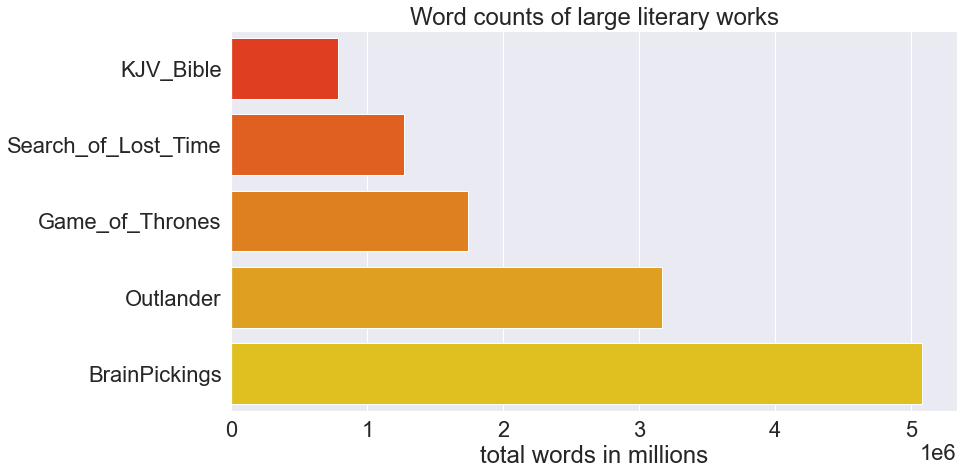

In [13]:
palette = "autumn"
f, ax = plt.subplots(figsize=(13, 7))
sns.set(font_scale=2)
words = dict(KJV_Bible=783000, Search_of_Lost_Time=1270000, Game_of_Thrones=1740000, Outlander=3170000, BrainPickings=5080000)
ax =sns.barplot(y=list(words.keys()), x=list(words.values()), palette=palette)
ax.set(xlabel='total words in millions', title="Word counts of large literary works");

In [14]:
year_article_counts = df.date.groupby(df.date.dt.year).agg("count")
year_article_counts

date
2007     21
2008    130
2009    263
2010    396
2011    754
2012    760
2013    745
2014    702
2015    549
2016    489
2017    258
2018    230
2019    197
2020    167
2021     37
Name: date, dtype: int64

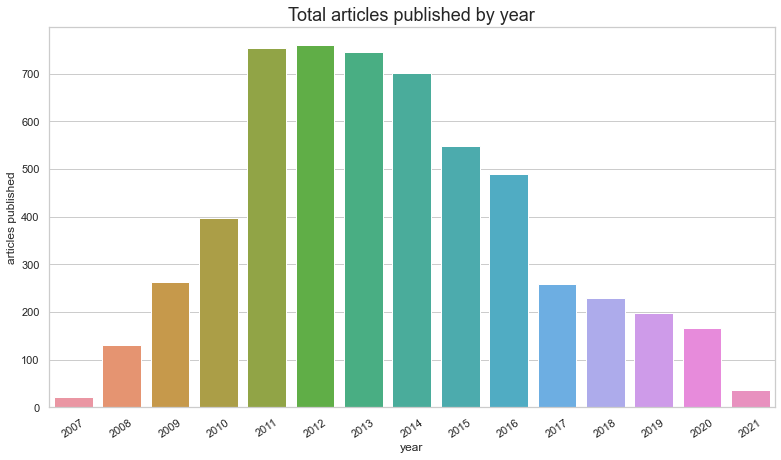

In [16]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 7))
sns.set(font_scale=1.5)
#ax = sns.barplot(x=year_word_counts.index, y=year_word_counts.values)
ax = sns.barplot(x=year_article_counts.index,y=year_article_counts.values)
ax.set(xlabel='year', ylabel='articles published', title="Total articles published by year")
plt.xticks(rotation=34);

In [18]:
year_word_counts = df.words.groupby(df.date.dt.year).agg("sum")
year_word_counts

date
2007     30893
2008     67598
2009     95319
2010    140938
2011    336249
2012    505655
2013    761746
2014    855349
2015    664427
2016    587429
2017    306642
2018    262590
2019    252131
2020    173273
2021     43959
Name: words, dtype: int64

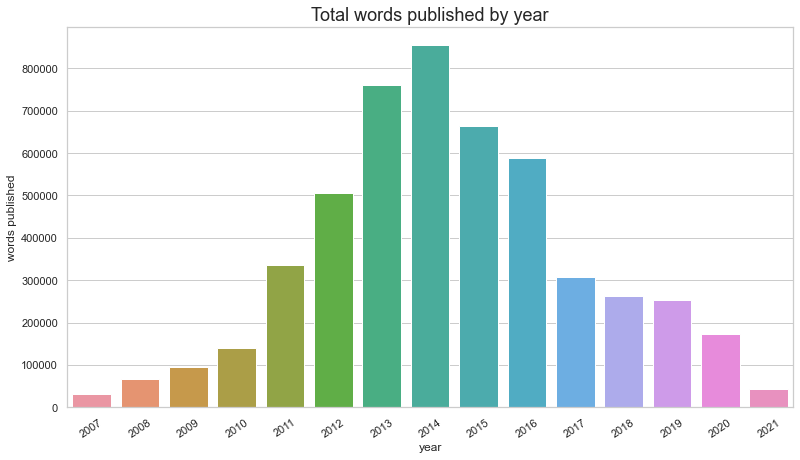

In [19]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 7))
sns.set(font_scale=1.5)
ax = sns.barplot(x=year_word_counts.index,
                 y=year_word_counts.values)
ax.set(xlabel='year', ylabel='words published', title="Total words published by year")
plt.xticks(rotation=34);

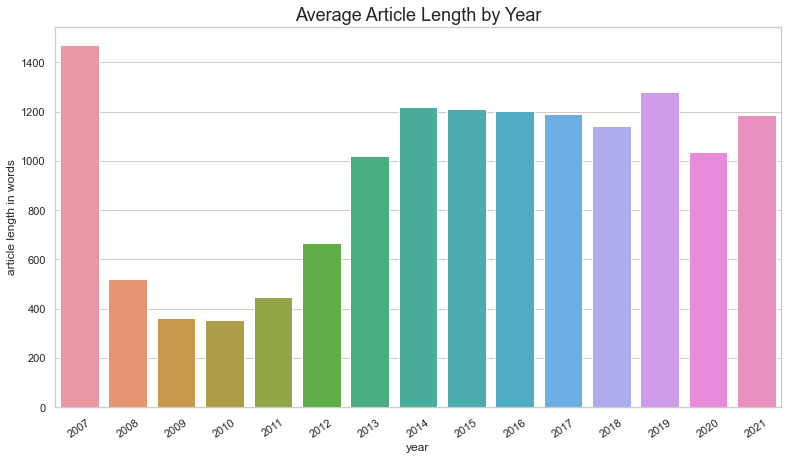

In [21]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(13, 7))
sns.set(font_scale=1.5)
year_article_length = round(year_word_counts/year_article_counts)
ax = sns.barplot(x=year_article_length.index,
                 y=year_article_length.values)
ax.set(xlabel='year', ylabel='article length in words', title="Average Article Length by Year")
plt.xticks(rotation=34);

In [221]:
#create a tag dictionary
tags = str()
for tag in df.tags: tags += tag
tag_dict = dict()
for tag in tags.split():
    tag = tag.replace(",","")
    if tag in tag_dict:
        tag_dict[tag] += 1
    else:
        tag_dict[tag] = 1

In [266]:
from heapq import nlargest
#top 22 tags
N=22
res = nlargest(N, tag_dict, key=tag_dict.get)
top_tags = dict()
for r in res:
    top_tags[r] = tag_dict[r]
top_tags

{'culture': 5129,
 'books': 3636,
 'art': 2108,
 'psychology': 1547,
 'science': 1213,
 'philosophy': 1150,
 'history': 1082,
 'design': 863,
 'picked': 682,
 'illustration': 633,
 'politics': 518,
 'childrens-books': 483,
 'cinema': 477,
 'music': 441,
 'creativity': 418,
 'letters': 408,
 'poetry': 402,
 'film': 387,
 'technology': 357,
 'photography': 334,
 'animation': 302,
 'love': 292}

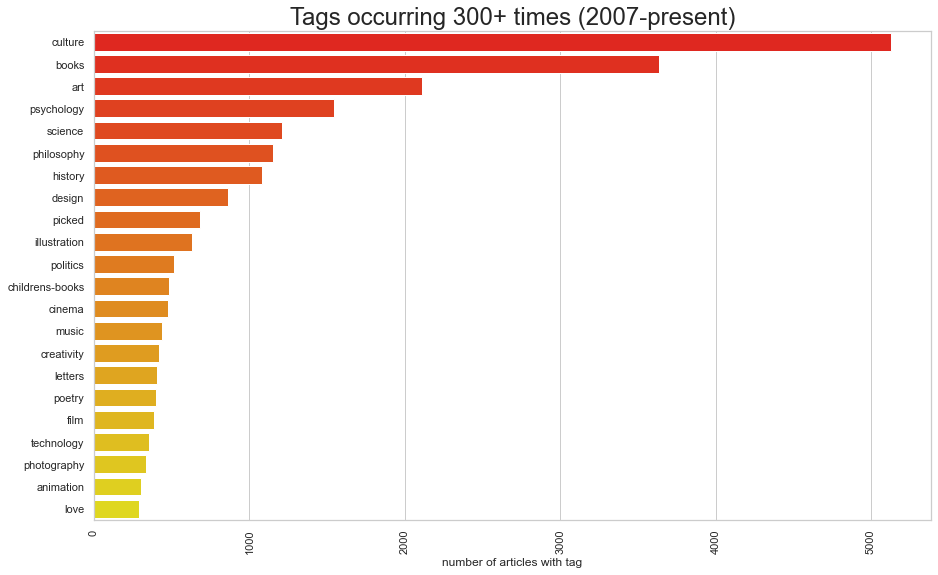

In [272]:
f, ax = plt.subplots(figsize=(15, 9))
sns.set(font_scale=2)
ax =sns.barplot(y=list(top_tags.keys()),
                x=list(top_tags.values()), palette=palette)
ax.set(xlabel='number of articles with tag', title="Tags occurring 300+ times (2007-present)");
plt.xticks(rotation=90);

In [23]:
#the corpus...
documents = df.title + df.content

In [24]:
vectorizer = CountVectorizer(strip_accents="unicode", analyzer="word", min_df=1, stop_words=None)
X = vectorizer.fit_transform(documents)
vocabulary = vectorizer.get_feature_names()

In [48]:
len(vocabulary)

70998

In [27]:
#Enchant is an English dictionary
vocab_enchant = list()
d = enchant.Dict("en_US")
#if a word in the corpus is in the enchant dictionary, it is included
for word in vocabulary:
    if d.check(word):
        vocab_enchant.append(word)
len(vocab_enchant)

42559

In [46]:
vocab_lemmatized = list()
lemmatizer = WordNetLemmatizer()
#Lemmatization is the process of grouping together the different inflected forms of a word
for word in vocab_enchant:
    vocab_lemmatized.append(lemmatizer.lemmatize(word))
    
vocab_lemmatized = sorted(list(set(vocab_lemmatized)))
vocab_str = str()
for word in vocab_lemmatized:
    vocab_str += word + ", "
#this is a good estimate of Maria Popova's working vocabulary
#her true vocabulary is probably double this
len(vocab_lemmatized)

34999

In [47]:
#wordy mcwordiness
vocab_str

'TM, a, aardvark, ab, aback, abacus, abandon, abandoned, abandoning, abandonment, abasement, abashed, abate, abated, abatement, abating, abattoir, abbe, abbey, abbot, abbreviate, abbreviated, abbreviating, abbreviation, abdicate, abdicated, abdicating, abdication, abdomen, abdominal, abducted, abductee, abductees, abduction, abed, aberrant, aberration, abet, abetted, abeyance, abhor, abhorred, abhorrence, abhorrent, abhors, abide, abides, abiding, abidingly, ability, abject, abjection, abjectly, ablation, ablaze, able, abloom, ablution, abnegation, abnormal, abnormality, abnormally, aboard, abode, abolish, abolished, abolishing, abolition, abolitionist, abominable, abominably, abomination, aboriginal, aborigine, abortion, abound, abounded, abounding, abounds, about, above, abracadabra, abraded, abrading, abrasion, abrasive, abrasively, abrasiveness, abreast, abridge, abridged, abridgment, abroad, abrupt, abruptly, abruptness, abscess, abscission, abscond, absconding, absence, absent, a

In [311]:
analyze = vectorizer.build_analyzer()

# Compare Stemming/Lemmatization

In [10]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()

docs_porter = [[porter.stem(word) for word in words]
               for words in doc_filter]
docs_snowball = [[snowball.stem(word) for word in words]
                 for words in doc_filter]
docs_wordnet = [[wordnet.lemmatize(word) for word in words]
                for words in doc_filter]

### Results

In [11]:
## Print the stemmed and lemmatized words from the first document
print("%16s | %16s | %16s | %16s |" % ("WORD", "PORTER", "SNOWBALL", "LEMMATIZER"))
for i in range(min(len(docs_porter[0]), len(docs_snowball[0]), len(docs_wordnet[0]))):
    p, s, w = docs_porter[0][i], docs_snowball[0][i], docs_wordnet[0][i]
    if len(set((p, s, w))) != 1:
        print("%16s | %16s | %16s | %16s |" % (doc_filter[0][i], p, s, w))

            WORD |           PORTER |         SNOWBALL |       LEMMATIZER |
         hovered |            hover |            hover |          hovered |
          looked |             look |             look |           looked |
      helicopter |         helicopt |         helicopt |       helicopter |
          stayed |             stay |             stay |           stayed |
     disappeared |        disappear |        disappear |      disappeared |
         appears |           appear |           appear |          appears |
              us |               us |               us |                u |
      consistent |          consist |          consist |       consistent |
        sighting |            sight |            sight |         sighting |
           venus |             venu |            venus |            venus |


### Snowball Stemmer Chosen
> We chose to stem the words with the Snowball Stemmer due to its preservation of important words for this usecase such as 'venus'


> The Snowball Stemmmer normalizes these words from its appeared form into their root form

In [12]:
# Stem Words in Each Document
clean_tokens = [list(map(snowball.stem, sent)) for sent in doc_filter]
# clean_tokens

In [13]:
# Check for stray tokens (ones with weird puncs, not alphabetical strings)
strays = []
for i in range(len(clean_tokens)):
#     print("--- sentence tokens (lemmatize): {}".format(tokens_lemmatize[i]))
    for word in clean_tokens[i]:
        if not word.isalpha():
            strays.append(word)
set(strays)

set()

### Turn Cleaned Tokens into Series

In [14]:
# Documents to series
document_series = pd.Series([" ".join(x) for x in clean_tokens])

In [15]:
documents[0]

"Light seen over mountain's east of Camp McGregor.  It hovered in one spot.  It looked like a helicopter light at first.  But it was way to bright.  Then it went to a higher height.  Stayed there for a while.  Then disappeared.((NUFORC Note:  Report appears to us to be consistent with the sighting of Venus.  PD))"

In [16]:
document_series[0]

'light seen mountain east camp mcgregor hover one spot look like helicopt light first way bright went higher height stay disappear nuforc note report appear us consist sight venus pd'

### Get Term Frequency

In [17]:
# term occurence = counting distinct words in each bag
term_occ = [Counter(doc) for doc in clean_tokens]
# term_occ

The number of times a term occurs in a specific document:

$tf(term,document) = \frac{\# \ of \ times \ a \ term \ appears \ in \ a \ document}{\#\ of\ terms\ in\ the\ document|}$

In [18]:
term_freq = list()
for i in range(len(clean_tokens)):
    term_freq.append( {k: (v / float(len(clean_tokens[i])))
                       for k, v in term_occ[i].items()} )
term_freq[0]

{'light': 0.06666666666666667,
 'seen': 0.03333333333333333,
 'mountain': 0.03333333333333333,
 'east': 0.03333333333333333,
 'camp': 0.03333333333333333,
 'mcgregor': 0.03333333333333333,
 'hover': 0.03333333333333333,
 'one': 0.03333333333333333,
 'spot': 0.03333333333333333,
 'look': 0.03333333333333333,
 'like': 0.03333333333333333,
 'helicopt': 0.03333333333333333,
 'first': 0.03333333333333333,
 'way': 0.03333333333333333,
 'bright': 0.03333333333333333,
 'went': 0.03333333333333333,
 'higher': 0.03333333333333333,
 'height': 0.03333333333333333,
 'stay': 0.03333333333333333,
 'disappear': 0.03333333333333333,
 'nuforc': 0.03333333333333333,
 'note': 0.03333333333333333,
 'report': 0.03333333333333333,
 'appear': 0.03333333333333333,
 'us': 0.03333333333333333,
 'consist': 0.03333333333333333,
 'sight': 0.03333333333333333,
 'venus': 0.03333333333333333,
 'pd': 0.03333333333333333}

### Get Document Frequencies

$df(term,corpus) = \frac{ \# \ of \ documents \ that \ contain \ a \ term}{ \# \ of \ documents \ in \ the \ corpus}$

In [28]:
doc_occ = Counter( [word for token in clean_tokens for word in set(token)] )

doc_freq = {k: (v / float(len(clean_tokens)))
            for k, v in doc_occ.items()}

# doc_freq

In [20]:
# See words with a high frequency threshhold 50%
thresh = 0.5
for word, freq in doc_freq.items():
    if freq >= thresh:
        print(f"{word}:  {freq}")

light:  0.6767676767676768
look:  0.5252525252525253
sky:  0.5656565656565656
saw:  0.5151515151515151
move:  0.5858585858585859


### Get Vocabulary

In [21]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.5

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),vocabulary))

-- vocabulary (len=5): ['light', 'look', 'sky', 'saw', 'move']


(array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 [157, 54, 15, 10, 5, 1, 0, 0, 0, 0])

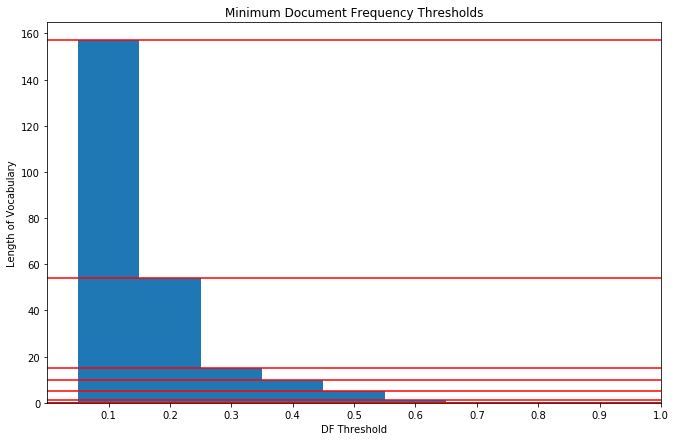

In [22]:
# Plot Minimum Document Frequency Threshold
x = np.arange(0.1, 1.1, 0.1)
vocab_y = [len([ k for k,v in doc_freq.items() if v >= thresh ]) for thresh in x]

fig, ax = plt.subplots(figsize=(11, 7))

ax.bar(x, vocab_y, width=0.1)

ax.set_xlim([0,1])
ax.set_title("Minimum Document Frequency Thresholds")

ax.set_xticks(x)

ax.set_xlabel("DF Threshold")
ax.set_ylabel("Length of Vocabulary")

for i, j in zip(x, vocab_y):
    ax.axhline(j, color='r')

x, vocab_y

In [23]:
all_vocabs = [[ k for k,v in doc_freq.items() if v >= thresh ] for thresh in x]
for vocab in all_vocabs:
    print("-- vocabulary (len={}): {}".format(len(vocab),vocab))

-- vocabulary (len=157): ['light', 'look', 'nuforc', 'helicopt', 'first', 'bright', 'pd', 'disappear', 'way', 'went', 'sight', 'report', 'seen', 'us', 'one', 'like', 'east', 'appear', 'note', 'hover', 'could', 'sky', 'provid', 'elect', 'stationari', 'star', 'inform', 'anonym', 'contact', 'remain', 'sourc', 'travel', 'notic', 'fli', 'someth', 'approxim', 'clear', 'see', 'would', 'wit', 'sound', 'come', 'direct', 'near', 'craft', 'saw', 'west', 'air', 'north', 'feet', 'object', 'tree', 'mayb', 'shape', 'side', 'view', 'size', 'orang', 'circl', 'never', 'hous', 'gone', 'pass', 'time', 'seem', 'move', 'low', 'almost', 'straight', 'white', 'plane', 'still', 'anoth', 'know', 'quick', 'toward', 'made', 'outsid', 'normal', 'stop', 'make', 'flash', 'mile', 'distanc', 'high', 'insid', 'chang', 'thought', 'go', 'minut', 'back', 'second', 'watch', 'show', 'around', 'two', 'ball', 'even', 'away', 'night', 'south', 'thing', 'came', 'point', 'color', 'end', 'green', 'complet', 'take', 'drive', 'refle

In [24]:
state_df = clean_df.groupby('state')["content"]

# Language Processing

### Create TFIDF Vector

$df(term,corpus) = \frac{ \# \ of \ documents \ that \ contain \ a \ term}{ \# \ of \ documents \ in \ the \ corpus}$

The inverse document frequency is defined in terms of the document frequency as

$idf(term,corpus) = \log{\frac{1}{df(term,corpus)}}$.


TF-IDF is an acronym for the product of two parts: the term frequency tf and what is called the inverse document frequency idf. The term frequency is just the counts in a term frequency vector. 

tf-idf $ = tf(term,document) * idf(term,corpus)$

In [25]:
tf = CountVectorizer()

document_tf_matrix = tf.fit_transform(document_series).todense()

#print(tf.vocabulary_)
#print(document_tf_matrix)

In [26]:
def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
#print(sorted(tf.vocabulary_))
#print(idf(document_tf_matrix))

In [27]:
tfidf = TfidfVectorizer()
document_tfidf_matrix = tfidf.fit_transform(document_series)
print(sorted(tfidf.vocabulary_))
print(document_tfidf_matrix.todense())

['abl', 'abrupt', 'absolut', 'acceler', 'accord', 'account', 'acknowledg', 'acr', 'across', 'act', 'activ', 'actual', 'addendum', 'address', 'adjac', 'adrenalin', 'advertis', 'aerial', 'aerodynam', 'afbwhil', 'afraid', 'afternoon', 'againmi', 'agil', 'agl', 'ago', 'agre', 'ahead', 'air', 'aircraft', 'airforc', 'airlin', 'airplan', 'airplanew', 'airport', 'alabama', 'alarm', 'albani', 'albuquerqu', 'alien', 'alleg', 'allow', 'almost', 'alon', 'along', 'alot', 'alreadi', 'also', 'although', 'altitud', 'altitudei', 'aluminum', 'alway', 'amaz', 'amber', 'amend', 'anchorag', 'andi', 'andrew', 'angel', 'angl', 'anniston', 'anonym', 'anoth', 'answer', 'antiqu', 'anxieti', 'anybodi', 'anymor', 'anyon', 'anyth', 'anywher', 'apart', 'appar', 'appear', 'appendag', 'approach', 'approx', 'approxim', 'approximatley', 'april', 'aprox', 'arang', 'arc', 'arch', 'area', 'arizona', 'arm', 'armi', 'around', 'arrang', 'array', 'arrow', 'asap', 'ascertain', 'ask', 'asleep', 'aspirin', 'assum', 'asteroid', '